Saved figure to NumberOfTrain.pdf


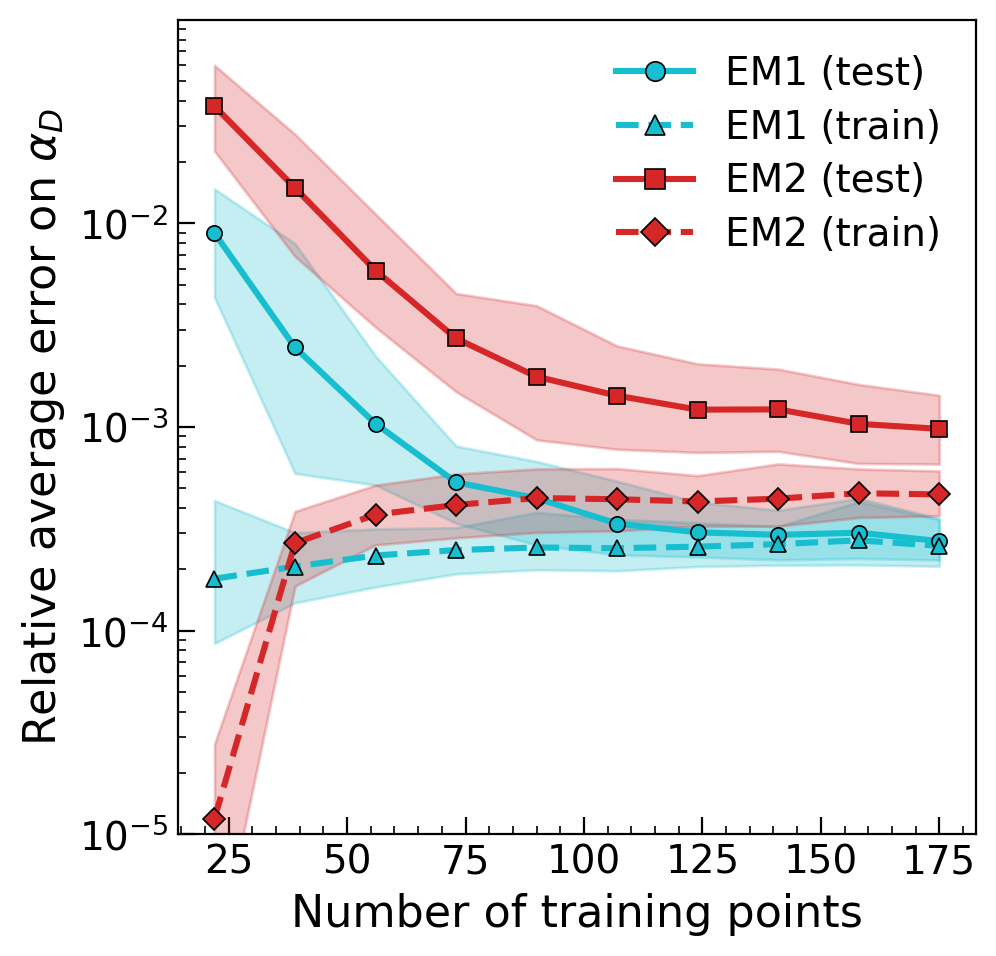

In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.lines import Line2D


# ========= User config =========
n = [22, 39, 56, 73, 90, 107, 124, 141, 158, 175]
tiers = range(1, 11)
seeds = [123 + i for i in range(100)]

# CSV layout:
# ../dipoles_exp_param/alphaD_eval_{Em1|Em2}_{seed}/alphaD_relerr_{test|train}_tier{i}.csv
root_fmt = "../dipoles_exp_param/alphaD_samples/alphaD_eval_{em_tag}_{seed}/alphaD_relerr_{sets}_tier{tier}.csv"

# --- emulator brand colors ---
EM1_COLOR = "#17becf"   # Emulator 1
EM2_COLOR = "#d62728"   # Emulator 2

OUT_FIG = "NumberOfTrain.pdf"
# ===============================

# ---- Matplotlib look/feel ----
plt.rcParams.update({
    "figure.dpi": 150,
    "savefig.dpi": 300,
    "font.size": 14,
    "axes.titlesize": 15,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.minor.visible": True,
    "ytick.minor.visible": True,
    "xtick.major.size": 6,
    "xtick.minor.size": 3,
    "ytick.major.size": 6,
    "ytick.minor.size": 3,
    "axes.grid": False,
    "grid.alpha": 0.25,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14
})

# ---- Data loader for one emulator/setting ----
def collect_seed_curves(em_tag: str, sets: str):
    """Returns per-seed arrays of mean rel_abs per tier. Skips incomplete seeds."""
    per_seed = []
    for seed in seeds:
        ok = True
        vals = []
        for t in tiers:
            csv_path = root_fmt.format(em_tag=em_tag, seed=seed, sets=sets, tier=t)
            if not os.path.exists(csv_path):
                ok = False
                break
            df = pd.read_csv(csv_path)
            vals.append(df["rel_abs"].to_numpy().mean())
        if ok:
            per_seed.append(np.asarray(vals, dtype=float))
    return per_seed

# ---- Plotting helper: 95% band on ORIGINAL grid (no interpolation/smoothing) ----
def plot_emulator_with_band(n_vals, em_tag, sets, color, label,
                            line_style="-", marker="o",
                            alpha_band=0.25, lw=2.2,
                            draw_seed_traces=False):
    per_seed = collect_seed_curves(em_tag, sets)
    if len(per_seed) == 0:
        print(f"[WARN] No complete seed curves found for {em_tag} / {sets}. Skipping.")
        return np.full(len(n_vals), np.nan), (np.full(len(n_vals), np.nan), np.full(len(n_vals), np.nan))

    per_seed = np.vstack(per_seed)  # (num_seeds, num_tiers)

    # Optional faint seed traces at original grid
    if draw_seed_traces:
        for row in per_seed:
            plt.plot(n_vals, row, "-", color=color, alpha=0.08, lw=1.0, zorder=1)

    # Statistics at original grid
    mean = per_seed.mean(axis=0)
    lo95 = np.percentile(per_seed, 2.5, axis=0)
    hi95 = np.percentile(per_seed, 97.5, axis=0)

    # 95% BAND: plotted directly on original x coordinates (no dense grid, no smoothing)
    plt.fill_between(n_vals, lo95, hi95, color=color, alpha=alpha_band, zorder=2)

    # CENTRAL LINE: only on original points
    plt.plot(n_vals, mean, color=color, linestyle=line_style, lw=lw, label=label, zorder=3)
    plt.plot(n_vals, mean, marker=marker, linestyle="none", color=color,
             mec="black", mew=0.6, markersize=5.5, zorder=4)

    return mean, (lo95, hi95)

# ================== Figure ==================
fig, ax = plt.subplots(figsize=(5.2, 5.0),dpi=200)
ax.set_yscale("log")
ax.set_xlabel(r"Number of training points", size=16)
ax.set_ylabel(r"Relative average error on $\alpha_D$", size=16)
ax.xaxis.set_major_locator(ticker.MultipleLocator(25))
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())

# Emulator 1
plot_emulator_with_band(n, "Em1", "test",  EM1_COLOR, "EM1 (test)",  "-",  "o")
plot_emulator_with_band(n, "Em1", "train", EM1_COLOR, "EM1 (train)", "--", "^")

# Emulator 2
plot_emulator_with_band(n, "Em2", "test",  EM2_COLOR, "EM2 (test)",  "-",  "s")
plot_emulator_with_band(n, "Em2", "train", EM2_COLOR, "EM2 (train)", "--", "D")

# ax.legend(frameon=False, loc="upper right", ncol=1)

# Custom legend: shows both the line and the marker
handles = [
    Line2D([0], [0], color=EM1_COLOR, lw=2.2, linestyle='-',
           marker='o', markersize=7, markerfacecolor=EM1_COLOR,
           markeredgecolor='black', markeredgewidth=0.6,
           label='EM1 (test)'),
    Line2D([0], [0], color=EM1_COLOR, lw=2.2, linestyle='--',
           marker='^', markersize=7, markerfacecolor=EM1_COLOR,
           markeredgecolor='black', markeredgewidth=0.6,
           label='EM1 (train)'),
    Line2D([0], [0], color=EM2_COLOR, lw=2.2, linestyle='-',
           marker='s', markersize=7, markerfacecolor=EM2_COLOR,
           markeredgecolor='black', markeredgewidth=0.6,
           label='EM2 (test)'),
    Line2D([0], [0], color=EM2_COLOR, lw=2.2, linestyle='--',
           marker='D', markersize=7, markerfacecolor=EM2_COLOR,
           markeredgecolor='black', markeredgewidth=0.6,
           label='EM2 (train)'),
]
ax.legend(handles=handles, frameon=False, loc='upper right',
          ncol=1, handlelength=2.0, labelspacing=0.4)


ax.set_ylim(1e-5, None)

plt.tight_layout()
fig.savefig(OUT_FIG, bbox_inches="tight")
print(f"Saved figure to {OUT_FIG}")
plt.show()


# 